In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime
import time
import swifter

# Data Loading

In [2]:
data = pd.read_csv('./modelready_data.csv')

In [3]:
data.head()

,UserId,Category,Country,Device,Genre,OS,ProgramType,State,VideoId,AppLaunchedFrequency,RegistrationFrequency,UTMVisitedFrequency,VideoStartedFrequency,VideoDetailsFrequency,AppUninstalledFrequency,LastSeen(in Hours),LastEvent(in 48H),WatchedVideo,WatchedVideo(in 48H)
0,0000146e97c32d369268e5ba5f4b907c,vod,1,1,Drama,1,TV Shows,36,f053c42e98d50e06532ce8d65afb3ab3,14.0,1.0,4.0,1.0,5.0,1.0,0,Yes,1,1
1,00001e3213a2159ed06f1db689c54fbb,vod,40,1,Comedy,1,Movies,33,94e0e078a2107fd19e6b375e193c3a93,4.0,1.0,1.0,1.0,4.0,1.0,0,Yes,1,1
2,00004010d92c2f13b824237bc323d58b,vod,40,2,Anime,1,TV Shows,33,edfe3711d865215486344ee2a545c0c1,1.0,1.0,2.0,1.0,4.0,1.0,0,Yes,1,1
3,000076c7bbdf7e4568777134cc4bec56,vod,1,1,Drama,2,TV Shows,35,f0961889cad44180693b249ad0718b78,9.0,1.0,1.0,9.0,4.0,1.0,0,Yes,0,0
4,0000e560394fce891dcf80218793d181,linear,1,1,Anime,1,Channels,40,7215ee9c7d9dc229d2921a40e899ec5f,10.0,1.0,1.0,9.0,17.0,1.0,0,Yes,1,1


# Dropping Features with high correlation

In [4]:
data = data.drop(['VideoId','WatchedVideo','LastEvent(in 48H)','LastSeen(in Hours)','VideoStartedFrequency','VideoDetailsFrequency','Category','ProgramType'],axis=1)
data.head()

,UserId,Country,Device,Genre,OS,State,AppLaunchedFrequency,RegistrationFrequency,UTMVisitedFrequency,AppUninstalledFrequency,WatchedVideo(in 48H)
0,0000146e97c32d369268e5ba5f4b907c,1,1,Drama,1,36,14.0,1.0,4.0,1.0,1
1,00001e3213a2159ed06f1db689c54fbb,40,1,Comedy,1,33,4.0,1.0,1.0,1.0,1
2,00004010d92c2f13b824237bc323d58b,40,2,Anime,1,33,1.0,1.0,2.0,1.0,1
3,000076c7bbdf7e4568777134cc4bec56,1,1,Drama,2,35,9.0,1.0,1.0,1.0,0
4,0000e560394fce891dcf80218793d181,1,1,Anime,1,40,10.0,1.0,1.0,1.0,1


In [5]:
data['WatchedVideo(in 48H)'].value_counts()

1    223637
0     40146
Name: WatchedVideo(in 48H), dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,recall_score,f1_score,accuracy_score,classification_report,roc_curve,confusion_matrix,precision_score
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Separate Target and Predictors

In [7]:
target = data.iloc[:,-1]
predictors = data.iloc[:,:-1]

In [8]:
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
predictors = dummyEncode(predictors)
target = pd.DataFrame(le.fit_transform(target))
predictors.head()

,UserId,Country,Device,Genre,OS,State,AppLaunchedFrequency,RegistrationFrequency,UTMVisitedFrequency,AppUninstalledFrequency
0,0,1,1,15,1,36,14.0,1.0,4.0,1.0
1,1,40,1,9,1,33,4.0,1.0,1.0,1.0
2,2,40,2,4,1,33,1.0,1.0,2.0,1.0
3,3,1,1,15,2,35,9.0,1.0,1.0,1.0
4,4,1,1,4,1,40,10.0,1.0,1.0,1.0


In [9]:
X_train,X_test,y_train,y_test = train_test_split(predictors,target, test_size=0.3, random_state=47)

# Vanilla Models

              precision    recall  f1-score   support

           0       0.36      0.05      0.08      5617
           1       0.85      0.99      0.91     31313

    accuracy                           0.84     36930
   macro avg       0.60      0.52      0.50     36930
weighted avg       0.78      0.84      0.79     36930

ROC_AUC_SCORE is 0.5153856931422869


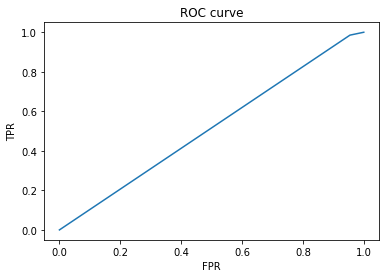

AUC Score = 51.54 %
On Model - 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.41      0.43      0.42      5617
           1       0.90      0.89      0.89     31313

    accuracy                           0.82     36930
   macro avg       0.65      0.66      0.66     36930
weighted avg       0.82      0.82      0.82     36930

ROC_AUC_SCORE is 0.659203640085053


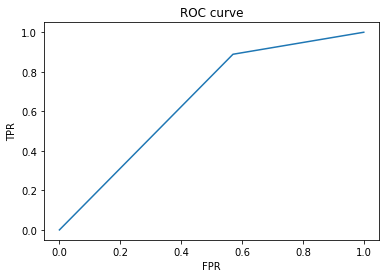

AUC Score = 65.92 %
On Model - 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

           0       0.55      0.43      0.48      5617
           1       0.90      0.94      0.92     31313

    accuracy                           0.86     36930
   macro avg       0.73      0.68      0.70     36930
weighted avg       0.85      0.86      0.85     36930

ROC_AUC_SCORE is 0.6824313041237866


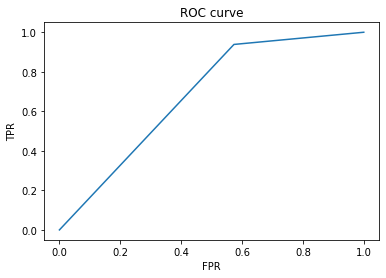

AUC Score = 68.24 %
On Model - 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.74      0.45      0.56      5617
           1       0.91      0.97      0.94     31313

    accuracy                           0.89     36930
   macro avg       0.82      0.71      0.75     36930
weighted avg       0.88      0.89      0.88     36930

ROC_AUC_SCORE is 0.7109203825149031


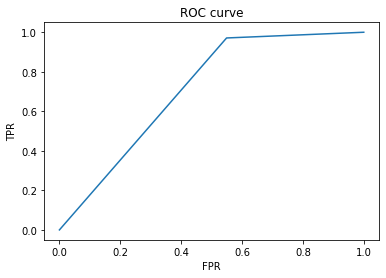

AUC Score = 71.09 %
On Model - 
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.73      0.45      0.55      5617
           1       0.91      0.97      0.94     31313

    accuracy                           0.89     36930
   macro avg       0.82      0.71      0.75     36930
weighted avg       0.88      0.89      0.88     36930

ROC_AUC_SCORE is 

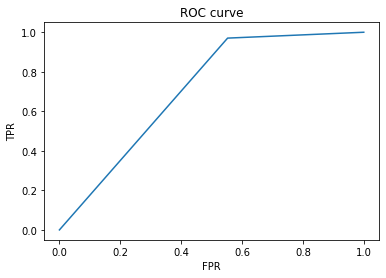

AUC Score = 70.89 %
On Model - 
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [10]:
def run_model(predictor_train,target_train, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = train_test_split(predictor_train,target_train,test_size=0.2,random_state=47)
    model.fit(x_train, y_train)
    y_scores = model.predict(x_val)
    auc = roc_auc_score(y_val, y_scores)
    print(classification_report(y_val,y_scores))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_scores))
    
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return auc

models = [LogisticRegression,DecisionTreeClassifier, RandomForestClassifier,XGBClassifier,GradientBoostingClassifier]
for model in models:
    # run model
    model = model()
    auc = run_model(X_train, y_train, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(model))
    print('===='*20)

# Observations:

| Models | ROC score|
|-|-|
| LogisticRegression | 51.54 % |
| DecisionTree | 65.92 % |
| RandomForestClassifier | 68.24 % |
| GradientBoostingClassifier | 71.09 % |
| XGBClassifier | 70.89 % |